In [88]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import sdeint
import seaborn as sns
sns.set(
    context='paper',
    style='ticks',
    palette='Set1',
    font_scale=2
)

def fig_xlabel(fig, label, x=0.5, y=0):
    return fig.text(x, y, label, horizontalalignment='center', verticalalignment='bottom')

def fig_ylabel(fig, label, x=0, y=0.5):
    return fig.text(x, y, label, rotation='vertical', horizontalalignment='right', verticalalignment='center')

def fig_panel_labels(axes, letters='ABCDEFGHIJKLMNOP', xcoord=-0.17, ycoord=0.92, panel_label_size=plt.rcParams[ 'axes.titlesize']*1.3):
    return [
        ax.annotate(letter, (xcoord, ycoord), xycoords='axes fraction', fontsize=panel_label_size)
        for ax, letter 
        in zip(axes.flat, letters)
    ]

In [118]:
def recurrence(x, t, η, ε, W, w):
    ωA, ωB = (W, w) if ε[t] == 1 else (w, W)
    meanω = x * ωA + (1 - x) * ωB
    return (x * ωA * ( (1 - η) * x + η) + (1 - x) * ωB * (1 - η) * x) / meanω

def μ(x, t, η, ε, W, w):
    ωA, ωB = (W, w) if ε[t] == 1 else (w, W)
    meanω = x * ωA + (1 - x) * ωB
    return η * x * (1 - x) * (ωA - ωB) / meanω
    
def σ2(x, t, η, ε, W, w):
    ωA, ωB = (W, w) if ε[t] == 1 else (w, W)
    meanω = x * ωA + (1 - x) * ωB
    return η**2 * x * (1 - x) * ((ωA + ωB) / meanω - 1)

def dxdt(x, t, η, ε, W, w):
    t = min(ε.size - 1, int(round(t, 0)))
    ωA, ωB = (W, w) if ε[t] == 1 else (w, W)
    meanω = x * ωA + (1 - x) * ωB
    return η * x * (1 - x) * (ωA - ωB) / meanω

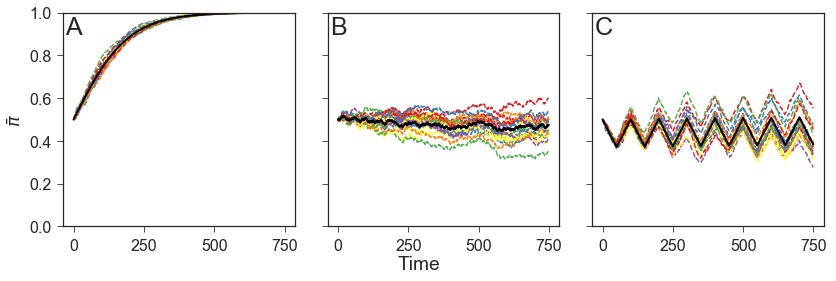

In [127]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

reps = 20
η, W, w = 0.1, 1, 0.9
t = np.arange(750, dtype=int)
x0 = 0.5
envs = [
    np.ones(t.size), 
    np.random.randint(0, 2, t.size), 
    np.array(([0] * 50 + [1] * 50)*10)
]

for ax, ε, letter in zip(axes.flat, envs, 'ABCDEFG'):
    assert ε.size >= t.size
    params = η, ε, W, w
    # recurrence
    x_r = np.empty_like(t, dtype=float)
    x_r[0] = x0
    for i in range(1, t.size):
        x_r[i] = recurrence(x_r[i - 1], i - 1, *params)
    # ode
#     x_o = odeint(dxdt, x0, t, args=params)    
    # diffusion
    x_d = np.array([
        sdeint.itoint(
            lambda x, t: μ(x, t, *params), 
            lambda x, t: σ2(x, t, *params), 
            x0, 
            t
        )
        for _ in range(reps)
    ]).squeeze().T
    # plot
    ax.plot(t, x_d, ls='--', label='diffusion')
    ax.plot(t, x_r, ls='-', lw=2, color='k', label='recurrence')
#     ax.plot(t, x_o, ls='-', label='ode')

# axes[0].legend()
axes[0].set(
    ylim=(0, 1),
    ylabel=r'$\bar{\pi}$'
)
fig_panel_labels(axes, xcoord=0.01, ycoord=0.9)
fig_xlabel(fig, 'Time')
fig.tight_layout()
plt.savefig('../figures/sde_example.pdf')

In [98]:
def A(x, η, W, w):
    return 2/η * (W-w)/(W+w-x*W-(1-x)*w)

In [99]:
from scipy.integrate import quad

In [100]:
def S(y, η, W, w):
    params = η, W, w
    return quad(lambda x: np.exp(-A(x, *params)), 0, y)[0]

In [101]:
A(0.1, 0.1, 1, 0.1)

19.78021978021978

In [102]:
S(0.1, 0.1, 1, 0.1)

7.303467604090805e-10

In [103]:
@np.vectorize
def u(x0, η, W, w):
    params = η, W, w
    up = quad(lambda x: np.exp(-A(x, *params)), 0, x0)[0]
    down = quad(lambda x: np.exp(-A(x, *params)), 0, 1)[0]
    return up / down

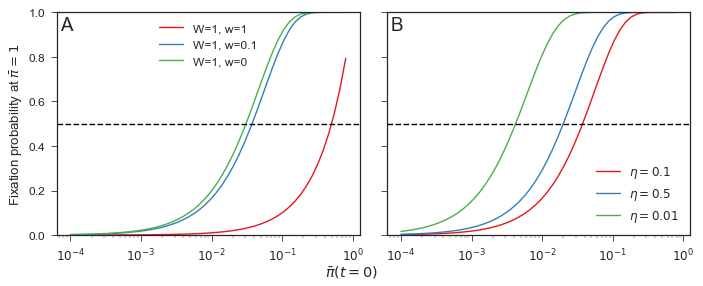

In [105]:
x0 = np.logspace(-4, -0.1)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

axes[0].plot(x0, u(x0, 0.1, 1, 1), label='W=1, w=1')
axes[0].plot(x0, u(x0, 0.1, 1, 0.1), label='W=1, w=0.1')
axes[0].plot(x0, u(x0, 0.1, 1, 0), label='W=1, w=0')
axes[0].axhline(0.5, ls='--', color='k')
axes[0].legend(loc='upper center')

axes[1].plot(x0, u(x0, 0.1, 1, 0.1), label=r'$\eta=0.1$')
axes[1].plot(x0, u(x0, 0.05, 1, 0.1), label=r'$\eta=0.5$')
axes[1].plot(x0, u(x0, 0.01, 1, 0.1), label=r'$\eta=0.01$')
axes[1].axhline(0.5, ls='--', color='k')
axes[1].legend(loc='lower right')

axes[0].set_xscale('log')
axes[0].set_ylim(0,1)
axes[0].set_ylabel(r'Fixation probability at $\bar{\pi}=1$')
fig_panel_labels(axes, xcoord=0.01, ycoord=0.92)
fig_xlabel(fig, r'$\bar{\pi}(t=0)$')
fig.tight_layout()
plt.savefig('../figures/diffusion_fix_prob.pdf')